# Handling Data & Practical Considerations

In this notebook you'll learn how to:

1. Save and load trained models
2. Write custom dataset classes for data on-disk
3. Split data into train/validation/test sets.

There are a couple of practical exercises throughout this notebook, and possible solutions at the end.

In [ ]:
!pip3 install torch torchaudio torchvision torchtext torchdata scikit-learn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 113.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 94.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

# Saving and Loading models

Once a neural network is trained, we usually want to save that network for us to re-use at a later point. This can either be to continue training, or to use a model for inference.

Here we'll set a model, and train it on the Imagenette dataset for a few epochs - then save the model.

You'll want to take a copy of the notebook and switch to the **GPU** runtime to train this.

In [ ]:
# Set up some useful imports.

%matplotlib inline
# Unless you're running in a notebook, ignore the above line.

import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:

# Resize to 32x32 for now, as otherwise the examples will take too long to run
# Can change this to see impact on training.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((32, 32))])

training_set = torchvision.datasets.Imagenette('.', split="train", size="320px", transform=transform, download=True)
training_loader = torch.utils.data.DataLoader(training_set, batch_size=32, shuffle=True)

class INetCNN(torch.nn.Module):
    def __init__(self):
      super(INetCNN, self).__init__()
      self.res = int(32 / 4)
      self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(3, 3), padding='same')
      self.conv2 = torch.nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), padding='same')
      self.fc1 = torch.nn.Linear(in_features=self.res*self.res*8, out_features=10)

      self.maxpool = torch.nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = self.maxpool(x)

      x = F.relu(self.conv2(x))
      x = self.maxpool(x)

      x = x.view(-1, self.res * self.res * 8)
      x = self.fc1(x)

      return x

# Create the model object from the class
cnn = INetCNN()
cnn = cnn.to('cuda')
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

def train_model(model, opt, dataloader, epochs, name):
  loss_fn = torch.nn.CrossEntropyLoss()
  epoch_losses = []

  for epoch in range(0, epochs):
    epoch_loss = 0
    # Run in a loop for n epochs
    for idx, data in enumerate(dataloader):
      inputs, labels = data

      # If we place the model on the GPU, the training data also needs to be on the GPU.
      inputs = inputs.to('cuda')
      labels = labels.to('cuda')

      opt.zero_grad()

      outputs = model(inputs)

      loss = loss_fn(outputs, labels)

      loss.backward()
      opt.step()

      epoch_loss += loss.item()

    print(f"Model: {name} Epoch {epoch} loss: {epoch_loss / len(training_loader)}")
    epoch_losses.append(epoch_loss / len(training_loader))

  return epoch_losses

# Train for three epochs
cnn_loss = train_model(cnn, optimizer, training_loader, 3, "CNN")

print(f"Loss after 3 epochs: {cnn_loss[-1]}")

Model: CNN Epoch 0 loss: 2.29879168561987
Model: CNN Epoch 1 loss: 2.284237662682662
Model: CNN Epoch 2 loss: 2.2300240389398627
Loss after 3 epochs: 2.2300240389398627


We can then save the model after this training run has completed.

This will be saved into the colab filestore (access by pressing the folder icon on the left).

In [ ]:
# To save the model for resuming training later:
# "state_dict" represents the current state of the model weights.
# optimizer_state_dict: represents the current state of the optimizer.

torch.save({'epoch': 3,
            'model_state_dict': cnn.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': cnn_loss[-1]
            },
           'cnn_model.pt')

Loading the model back from the disk is another few lines of code:

In [ ]:
# Clear out the old CNN model
cnn = None

# Re-declare the model as another instance of the INetCNN class.
# Note, this has randomly initialised weights.
cnn = INetCNN()

# Re-declare the optimiser (same class as above)
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

# Put the model back on the GPU
cnn = cnn.to('cuda')
# Load the saved data
saved_model_data = torch.load('cnn_model.pt', weights_only=True)

cnn.load_state_dict(saved_model_data['model_state_dict'])
optimizer.load_state_dict(saved_model_data['optimizer_state_dict'])

# We can then resume training (or just use the rebuilt model for inference.)
# This re-uses the original training function.
train_model(cnn, optimizer, training_loader, 5, "CNN")

# The loss from the first "restarted" epoch should be lower than the last saved epoch.

Model: CNN Epoch 0 loss: 2.073998057761708
Model: CNN Epoch 1 loss: 1.9624018793975986
Model: CNN Epoch 2 loss: 1.8958955056763984
Model: CNN Epoch 3 loss: 1.8314693400988709
Model: CNN Epoch 4 loss: 1.7774063562219207


[2.073998057761708,
 1.9624018793975986,
 1.8958955056763984,
 1.8314693400988709,
 1.7774063562219207]

# Custom Datasets

Practically, you're likely to want to use your *own* data, rather than data that's packaged with torch.

PyTorch provides a convenience class `Dataset` which makes it easy to do this.

To demonstrate, this notebook will contain two examples of custom built dataset classes: one for tabular data, and one for image data.

Knowing how to implement this allows you to create your own models with your own data; the general structure of the dataset class remains the same no matter the data.

First we'll download the [iris](https://en.wikipedia.org/wiki/Iris_flower_data_set) CSV data (click the File icon on the left if you'd like to inspect the filesystem structure).

In [ ]:
!rm iris.csv
!wget https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv

rm: cannot remove 'iris.csv': No such file or directory
--2025-05-21 13:28:46--  https://gist.githubusercontent.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3975 (3.9K) [text/plain]
Saving to: ‘iris.csv’

iris.csv            100%[===================>]   3.88K  --.-KB/s    in 0s      

2025-05-21 13:28:46 (50.4 MB/s) - ‘iris.csv’ saved [3975/3975]



We'll now define a dataset class which can load this CSV, and return individual (sample, label) datapoints.

In [ ]:
import pandas as pd
from torch.utils.data import Dataset

# Custom datasets inherit from the Pytorch Dataset class.
class IrisDataset(Dataset):
  def __init__(self):
    """
    In the __init__ method, you define how the data is loaded.
    Usually, the data will come from the disk.

    Here, we'll use pandas to read a CSV and store the data.
    We'll also define a class mapping to turn string labels into an integer value.
    (This could be a class variable, but we're keeping it simple)
    """
    self.data = pd.read_csv("./iris.csv")
    self.label_to_class_mapping = {'Setosa': 0,
                                   'Versicolor': 1,
                                   'Virginica': 2}
  def __len__(self):
    """
    Implement this function to allow the len() function to be called on the dataset
    Should contain logic for determining how "big" the dataset is. This is
    usually number of samples.
    """
    return self.data.shape[0]

  def __getitem__(self, idx):
    """
    Define logic for obtaining a single element of the data, which usually
    returns as a (sample, label) tuple.
    """
    data_row = self.data.iloc[idx].tolist()

    # (Quick cast to float32 instead of float64)
    return [x.astype(np.float32) for x in data_row[0:4]], self.label_to_class_mapping[data_row[-1]]



iris_data = IrisDataset()
print(iris_data[0])
print(f"Total dataset length: {len(iris_data)}")

([np.float32(5.1), np.float32(3.5), np.float32(1.4), np.float32(0.2)], 0)
Total dataset length: 150


In [ ]:
import pandas as pd
from torch.utils.data import Dataset

class IrisDataset(Dataset):
  def __init__(self):
    self.data = pd.read_csv("./iris.csv")
    self.label_to_class_mapping = {'Setosa': 0,
                                   'Versicolor': 1,
                                   'Virginica': 2}
  def __len__(self):
    return self.data.shape[0]

  def __getitem__(self, idx):
    data_row = self.data.iloc[idx].tolist()
    return torch.Tensor([x.astype(np.float32) for x in data_row[0:4]]), self.label_to_class_mapping[data_row[-1]]



iris_data = IrisDataset()
print(iris_data[0])
print(f"Total dataset length: {len(iris_data)}")

(tensor([5.1000, 3.5000, 1.4000, 0.2000]), 0)
Total dataset length: 150


You can build dataloaders with your custom dataset.

In [ ]:
iris_loader = torch.utils.data.DataLoader(iris_data, batch_size=4, shuffle=False)

for idx, batch in enumerate(iris_loader):
  inputs, labels = batch
  print(inputs)
  print(labels)

  # Just for illustration, we'll only grab the first eight batches.
  if idx >= 7:
    break

tensor([[5.1000, 3.5000, 1.4000, 0.2000],
        [4.9000, 3.0000, 1.4000, 0.2000],
        [4.7000, 3.2000, 1.3000, 0.2000],
        [4.6000, 3.1000, 1.5000, 0.2000]])
tensor([0, 0, 0, 0])
tensor([[5.0000, 3.6000, 1.4000, 0.2000],
        [5.4000, 3.9000, 1.7000, 0.4000],
        [4.6000, 3.4000, 1.4000, 0.3000],
        [5.0000, 3.4000, 1.5000, 0.2000]])
tensor([0, 0, 0, 0])
tensor([[4.4000, 2.9000, 1.4000, 0.2000],
        [4.9000, 3.1000, 1.5000, 0.1000],
        [5.4000, 3.7000, 1.5000, 0.2000],
        [4.8000, 3.4000, 1.6000, 0.2000]])
tensor([0, 0, 0, 0])
tensor([[4.8000, 3.0000, 1.4000, 0.1000],
        [4.3000, 3.0000, 1.1000, 0.1000],
        [5.8000, 4.0000, 1.2000, 0.2000],
        [5.7000, 4.4000, 1.5000, 0.4000]])
tensor([0, 0, 0, 0])
tensor([[5.4000, 3.9000, 1.3000, 0.4000],
        [5.1000, 3.5000, 1.4000, 0.3000],
        [5.7000, 3.8000, 1.7000, 0.3000],
        [5.1000, 3.8000, 1.5000, 0.3000]])
tensor([0, 0, 0, 0])
tensor([[5.4000, 3.4000, 1.7000, 0.2000],
        

And that's all there is to it: the Pytorch Dataset class is a very helpful pattern for handling your data for machine learning.


**NB**: With the iris dataset, it's small enough we can load the entire CSV into memory. With many datasets, this won't be possible - especially if using images.

Instead, we can simply maintain a record of *where* the data is in the *\_\_init__* function (e.g, filepaths and names) and lazily load each image off the disk as required in the *\_\_getitem__* method with whichever image IO library you prefer.

This means you can train neural networks on datasets much larger than your available memory.

# Practical: Datasets

Try writing your own custom dataset for the CIFAR 10 dataset, downloaded below.

You can inspect the structure of the data by pressing the folder button.

The dataset will need to return an image, and a label representing that image.

To read the image from the disk, you might want to use `decode_image` from `torchvision.io`.

You may also want to use `pathlib` for convenience.

An example solution is provided at the end of the worksheet.

A skeleton is provided here.

In [ ]:
!git clone https://github.com/YoongiKim/CIFAR-10-images.git

Cloning into 'CIFAR-10-images'...
remote: Enumerating objects: 60027, done.
remote: Total 60027 (delta 0), reused 0 (delta 0), pack-reused 60027 (from 1)
Receiving objects: 100% (60027/60027), 19.94 MiB | 34.15 MiB/s, done.
Resolving deltas: 100% (59990/59990), done.
Updating files: 100% (60001/60001), done.


In [ ]:
# Any imports you want for manipulating the data.
from torch.utils.data import Dataset


class CIFAR10(Dataset):
  def __init__(self, path):
    """
    Initialise the dataset here, and set up how
    the data is represented within the class.

    I've added a path parameter here - this should point
    to the train/test directories. You can change this,
    if desired.
    """

  def __len__(self):
    """
    Return the length of your dataset.
    """
    return

  def __getitem__(self, idx):
    """
    Define how to load and return an individual item.
    """
    return x, y


# Test your dataset out!
dataset = CIFAR10('./CIFAR-10-images/train/')

# Try displaying some images.

# Train, Test, & Validation Sets

Datasets are generally divided into three different splits of data, ideally each of which contain roughly the same distribution of classes.

These are:

1. The Training Set (usually representing 70% of the data)
2. The Validation set (20% of the data)
3. The test set (10% of the data)

Percentages are guidelines - these can and do vary depending on dataset availability and task.

The **training set** is the data which the neural network is actively trained to predict on.

The **validation set** is data which the neural network is **not** trained on, but is evaluated on during training (e.g, once every epoch). This helps identify how the network is likely to perform on unseen data, if the network has stopped learning, and allows for hyperparameter tuning.

Inference is performed on the **test set** once the model is trained, and no more training will take place, in order to determine the effectiveness of the model on completely unseen data.


PyTorch provides a convenience method `torch.utils.data.random_split` which can convert an existing dataset object into an arbitrary number of splits.

Most existing datasets come pre-divided into train and test, meaning you only need to create a validation set.

With your own dataset - you can use this convenience function, or simply divide your data on the disk as you like.

We'll try this on the Iris dataset. Note, unless you set the random seed, each time you call this function the results will be different!

In [1]:
from torch.utils.data import random_split

# Divide the data into three splits: 70% train, 20% val, 10% test.
data_splits = random_split(iris_data, [0.7, 0.2, 0.1])

# This returns a list dataset Subset object.
print(data_splits)
print([len(x) for x in data_splits])

# Data loaders work the same
# E.g for the validation set


val_loader = torch.utils.data.DataLoader(data_splits[1], batch_size=4, shuffle=True)

for idx, batch in enumerate(val_loader):
  inputs, labels = batch
  print(inputs)
  print(labels)

  if idx >= 7:
    break


NameError: name 'iris_data' is not defined

# Practical: Bringing Everything Together

With your written CIFAR10 dataset, split the train set into an 80% training set, and a 20% validation set. The test set is available on the disk under a different direction.

Have a go at writing your own neural network (your choice of type, depth, optimisers, loss function, etc) and train this using your CIFAR10 datasets. Evaluate the validation accuracy after every epoch (you may need to refer to last weeks worksheet for hints).

Finally, once happy with your model, perform inference on the test set and see how well your network performs - examining the accuracy and the confusion matrix.

**Note**: When performing inference (validation/test) it's a good idea to first place the model in eval mode with a call to `model.eval()`. You can put the model back in training mode when finished with `model.train()`

**You may want to use the GPU**

An example solution is provided below.

# Solutions / Examples

## Dataset

torch.Size([3, 32, 32])
0


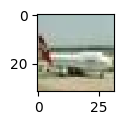

In [ ]:
import pathlib
from torch.utils.data import Dataset
from torchvision.io import decode_image

class CIFAR10(Dataset):
  def __init__(self, path):
    """
    Use the folder structure as the class labels.
    """

    self.labels = {
      'airplane': 0,
      'automobile': 1,
      'bird': 2,
      'cat': 3,
      'deer': 4,
      'dog': 5,
      'frog': 6,
      'horse': 7,
      'ship': 8,
      'truck': 9}

    self.x = list(pathlib.Path(path).glob('**/*.jpg'))
    self.y = [self.labels[str(x).split('/')[2]] for x in self.x]


  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    """
    Define logic for obtaining a single element of the data, which usually
    returns as a (sample, label) tuple.

    Here, we obtain the path, load the image, and return it.
    """

    image_path = str(self.x[idx])
    # Decode image loads an image as uint8 (0 - 255)
    # Practically, neural networks work better if image data is scaled between:
    # 0 and 1.0, or -1.0 and 1.0

    image = decode_image(image_path) / 255.0
    return image, self.y[idx]

dataset = CIFAR10('./CIFAR-10-images/train/')

x, y = dataset[0]

print(x.shape)
print(y)

%matplotlib inline
# Unless you're running in a notebook, ignore the above line.
import matplotlib.pyplot as plt
import numpy as np

npimg = x.numpy()
npimg = np.transpose(npimg, axes=(1, 2, 0))

fig, ax = plt.subplots(figsize=(1, 1))
ax.imshow(npimg, interpolation='nearest')
plt.show()


## Example network + training loop

Epoch 0 train loss: 2.1593704997062684 val loss: 1.96311441701822
Epoch 1 train loss: 1.9029505963325501 val loss: 1.8305570694585196
Epoch 2 train loss: 1.8166981955528259 val loss: 1.7777290100487657
Epoch 3 train loss: 1.7404281704902649 val loss: 1.6854327124909472
Epoch 4 train loss: 1.6200241158485413 val loss: 1.563881638331916
Epoch 5 train loss: 1.523363112926483 val loss: 1.5191501139071042
Epoch 6 train loss: 1.4775719767570497 val loss: 1.4722866619737764
Epoch 7 train loss: 1.4491109117507934 val loss: 1.4510788963244745
Epoch 8 train loss: 1.4264072360038758 val loss: 1.4574894939367764
Epoch 9 train loss: 1.407904039478302 val loss: 1.4614028302244484


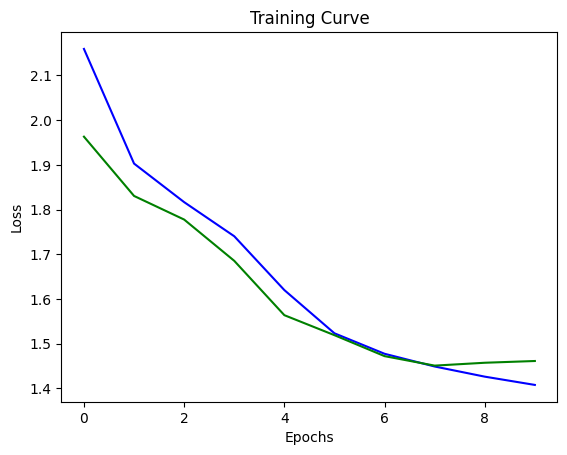

In [ ]:
# Set up some useful imports.

%matplotlib inline
# Unless you're running in a notebook, ignore the above line.

import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split

dataset = CIFAR10('./CIFAR-10-images/train/')

test_dataset = CIFAR10('./CIFAR-10-images/test/')
train_set, test_set = random_split(dataset, [0.8, 0.2])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

# Note the test set comes from the disk
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

class CifarCNN(torch.nn.Module):
    def __init__(self):
      super(CifarCNN, self).__init__()
      self.res = int(32 / 4)
      self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=4, kernel_size=(3, 3), padding='same')
      self.conv2 = torch.nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), padding='same')
      self.fc1 = torch.nn.Linear(in_features=self.res*self.res*8, out_features=10)

      self.maxpool = torch.nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = self.maxpool(x)

      x = F.relu(self.conv2(x))
      x = self.maxpool(x)

      # Flatten before applying the linear layer.
      x = x.view(-1, self.res * self.res * 8)
      x = self.fc1(x)

      return x

model = CifarCNN()
epoch_losses = []
validation_losses = []

model = model.to('cuda')

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10):
  epoch_loss = 0
  validation_loss = 0

  # Train the network
  for idx, data in enumerate(train_loader):
    inputs, labels = data

    # If we place the model on the GPU, the training data also needs to be on the GPU.
    inputs = inputs.to('cuda')
    labels = labels.to('cuda')

    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_fn(outputs, labels)

    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  # Validation loop
  # Enable evaluation mode.
  model.eval()
  for idx, data in enumerate(val_loader):
    inputs, labels = data
    inputs = inputs.to('cuda')
    labels = labels.to('cuda')

    with torch.no_grad():
      outputs = model(inputs)
      val_loss = loss_fn(outputs, labels)
      validation_loss += val_loss.item()

  # Switch back to training mode.
  model.train()

  print(f"Epoch {epoch} train loss: {epoch_loss / len(train_loader)} val loss: {validation_loss/len(val_loader)}")
  epoch_losses.append(epoch_loss / len(train_loader))
  validation_losses.append(validation_loss/len(val_loader))

plt.plot(range(0, len(epoch_losses)), epoch_losses, color='blue')
plt.plot(range(0, len(validation_losses)), validation_losses, color='green')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Curve")
plt.show()

Training complete - evaluating model
Accuracy: 48.49%


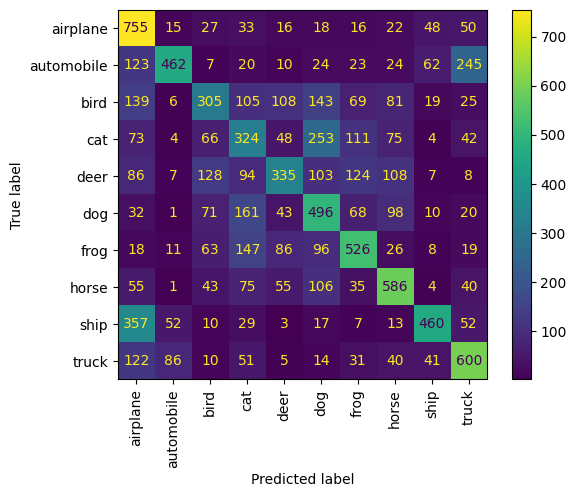

In [ ]:
# Evaluate test performance.
# In practice - these are likely to all be separate functions rather than in one
# long script.

print("Training complete - evaluating model")
model.eval()
total_correct = 0
all_y = np.array([])
all_labels = np.array([])

for idx, data in enumerate(test_loader):
  inputs, labels = data

  inputs = inputs.to('cuda')

  # Forward pass
  outputs = model(inputs)
  outputs = outputs.cpu()

  correct_output_vector = (labels == torch.argmax(outputs, axis=1))
  batch_correct = torch.sum(correct_output_vector)
  batch_correct = batch_correct.numpy()
  all_y = np.concatenate((all_y, torch.argmax(outputs, axis=1).numpy()))
  all_labels = np.concatenate((all_labels, labels.numpy()))

  total_correct += batch_correct

accuracy = (total_correct / len(test_set)) * 100
print(f"Accuracy: {np.round(accuracy, 2)}%")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_labels = dataset.labels.keys()

cm = confusion_matrix(all_labels, all_y)
ConfusionMatrixDisplay(cm, display_labels=class_labels).plot(xticks_rotation=90)